<a href="https://colab.research.google.com/github/rcadia/SEC_Scrape/blob/master/sec_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password

#set up the project for us, unzip an archive 
!rm -r 'sec_test'
!rm -r 'Archives'
!git clone https://$GITHUB_AUTH@github.com/oggonz/SEC_Scrape.git sec_test
!cp "sec_test/test_ticker_list.csv" "test_ticker_list.csv" #move ticker list to root
!cp "sec_test/Archives.zip" "Archives.zip" #move ticker list to root
!cp "sec_test/sec_R_utils.R" "sec_R_utils.R" #move ticker list to root
!cp "sec_test/sec_py_utils.py" "sec_py_utils.py" #move ticker list to root
!unzip -q Archives.zip

####
#edit the file ticker_list_csv for your own ticker set
####

GitHub user··········
GitHub password··········
rm: cannot remove 'sec_test': No such file or directory
rm: cannot remove 'Archives': No such file or directory
Cloning into 'sec_test'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 86 (delta 55), reused 86 (delta 55), pack-reused 0
Unpacking objects: 100% (86/86), done.


In [22]:
# activate R magic
# why use R here?  
# edgarWebR pulls sections really well

import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [32]:
%%R
#installs take a bit of time the first time...
print('Startup: install packages... (may take a few minutes the first time)')
library(devtools)

#handle false negatives from install_github
withr::with_envvar(c(R_REMOTES_NO_ERRORS_FROM_WARNINGS="true"), 
  remotes::install_github('mwaldstein/edgarWebR',quiet = TRUE)
)

#devtools::install_github("mwaldstein/edgarWebR",quiet = TRUE) 
print('Done with edgarWebR install')
devtools::install_github("r-lib/xml2",quiet = TRUE) #the CRAN xml breaks edgarWebR
print('Done with xml2 install')
#devtools::install_github("DavisVaughan/furrr")
install.packages('furrr',quiet = TRUE) #fine to use CRAN
print('Done with furr install')


[1] "Startup: install packages... (may take a few minutes the first time)"
[1] "Done with edgarWebR install"
[1] "Done with xml2 install"
[1] "Done with furr install"


In [33]:
%%R

#this run also can take a bit of time...
source('sec_R_utils.R')

#library from https://mwaldstein.github.io/edgarWebR/
suppressPackageStartupMessages(library(edgarWebR)) #this is an up to date library with an active maintainer.
suppressPackageStartupMessages(library(xml2))
suppressPackageStartupMessages(library(knitr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(purrr))
suppressPackageStartupMessages(library(rvest))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(readr))

#https://github.com/DavisVaughan/furrr
library(furrr) 

#read our ticker list
df_tickers <- read_csv('test_ticker_list.csv',col_types = cols()) 

#create our data folder
dir.create('sec_data_folder', showWarnings = FALSE)

#prep for multiprocessing
future::plan(multiprocess)

#tell us what we're doing
print(paste0('Running for ',nrow(df_tickers),' tickers.'))

#map get_document_text from sec_R_utils.R across the vector Symbol in the df_tickers dataframe
#show progress bar, thank you Davis 
df_data <- future_map_dfr(df_tickers$Symbol, get_document_text,.progress = TRUE) #takes a few minutes

print('done')



[1] "May_29_2020.log"
[1] "May_29_2020.csv"
[1] "Running for 10 tickers."
 Progress: ───────────────────────────────────────────────────              100%

R[write to console]: 

R[write to console]: Warning message:

R[write to console]: Missing column names filled in: 'X1' [1] 




Error in browse_edgar(x, ownership = ownership, type = type, before = before,  : 
  Could not find company: BRK.B
Calls: <Anonymous> ... resolve.list -> signalConditionsASAP -> signalConditions


In [35]:
#move from R to python

!pip install pandarallel
from sec_py_utils import *

import numpy as np
from pandarallel import pandarallel
import pandas as pd

pandarallel.initialize()

df_tickers = pd.read_csv('test_ticker_list.csv')

master_list_df = []
list_tickers = df_tickers['Symbol']

for ticker in list_tickers:
    py_write_log("working on..."+ticker)
    tic = time.perf_counter()

    if path.exists("sec_data_folder/"+ticker+".csv"):

        df_text = pd.read_csv("sec_data_folder/"+ticker+".csv")
        if len(df_text) > 0:

            df_text['ticker'] = ticker

            df_discussion = df_text[df_text['section']=='discussion']

            df_out = df_discussion.parallel_apply(func_sentiment, axis=1)
            df_out.columns = ['ticker','section','type','period_date','neu','neg','pos','compound','text','num_rows']
            
            if len(df_out) > 0:

                df_out = df_out.groupby(['ticker','period_date','type']).sum().reset_index()
                df_out['neg'] = df_out['neg']/df_out['num_rows']
                df_out['neu'] = df_out['neu']/df_out['num_rows']
                df_out['pos'] = df_out['pos']/df_out['num_rows']
                df_out['compound'] = df_out['compound']/df_out['num_rows']

                df_error = df_out[df_out['compound'] == 0]
                if not df_error.empty:
                    py_write_log("zero values..."+ticker)
                    df_error.to_csv('sec_nlp_errors.csv',mode = 'a')

                df_out['compound_baseline'] = df_out['compound'] / df_out['compound'].mean()
                df_out['neg_baseline'] = df_out['neg'] / df_out['neg'].mean()
                df_out['pos_baseline'] = df_out['pos'] / df_out['pos'].mean()
                df_out['compound_bdiff'] = df_out['compound_baseline'].diff()
                df_out['neg_bdiff'] = df_out['neg_baseline'].diff()
                df_out['pos_bdiff'] = df_out['pos_baseline'].diff()
                df_out['compound_zscore'] = (df_out['compound'] - df_out['compound'].mean())/df_out['compound'].std(ddof=0)

                #to iterate is human, to cache is divine
                str_score_file = "sec_data_folder/"+ticker+"_score.csv"
                df_out.to_csv(str_score_file)

                master_list_df.append(df_out)
            else:
                py_write_log("missing..."+ticker)
        else:
            py_write_log(ticker+" has no data.")
    toc = time.perf_counter()
    py_write_log(f"Text processed in {toc - tic:0.4f} seconds")

if master_list_df:
    df_data = pd.concat(master_list_df)
    df_data.to_csv('df_data.csv')

df = df_data[['period_date','ticker','compound_baseline']]
df['quarter_end'] = pd.to_datetime(df['period_date'])
df['quarter_end'] = df.quarter_end.map(lambda x: x.strftime('%Y-%m-%d'))

#modify odd quarter ends
df.loc[df.quarter_end == '2017-04-01', 'quarter_end'] = '2017-03-31'
df.loc[df.quarter_end == '2017-07-01', 'quarter_end'] = '2017-06-30'
df.loc[df.quarter_end == '2018-04-01', 'quarter_end'] = '2018-03-31'
df.loc[df.quarter_end == '2018-07-01', 'quarter_end'] = '2018-06-30'

df['quarter_end'] = pd.to_datetime(df['quarter_end'])
df['quarter_end'] = df['quarter_end'].dt.to_period('q').dt.end_time #floor at end of quarter
df['quarter_end'] = df.quarter_end.map(lambda x: x.strftime('%Y-%m-%d')) #format

import numpy as np
df_data_pivot = pd.pivot_table(df, values='compound_baseline', index=['quarter_end'],
                columns=['ticker'], aggfunc=np.sum, fill_value=0).reset_index()

df_data_pivot.to_csv("df_data_pivot.csv")

print('done!')




INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
working on...BRK.B
Text processed in 0.0001 seconds
working on...JPM
Text processed in 23.9398 seconds
working on...BAC
Text processed in 98.3204 seconds
working on...WFC
zero values...WFC
Text processed in 4.7844 seconds
working on...C
Text processed in 83.3721 seconds
working on...SPGI
Text processed in 32.4863 seconds
working on...CME
Text processed in 16.8413 seconds
working on...AXP
Text processed in 45.5948 seconds
working on...BLK
Text processed in 33.7071 seconds
working on...GS
Text processed in 80.4437 seconds
done!


In [37]:
########
#uncomment these lines to post df_data_pivot.csv to a google sheet
########

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials as GC
gc = gspread.authorize(GC.get_application_default())
from gspread_dataframe import set_with_dataframe
title = 'sec_nlp_data'
gc.create(title)  # if not exist
sheet = gc.open(title).sheet1
set_with_dataframe(sheet, df_data_pivot) 
print('done!')


done!


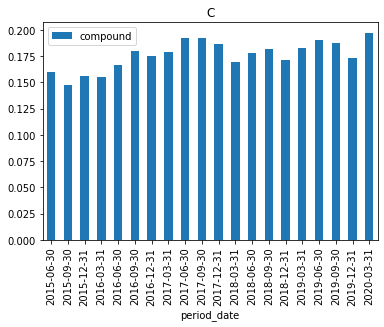

In [38]:
#a sample chart of one ticker.

pd.options.mode.chained_assignment = None
df_plot = df_data[df_data['ticker'] == 'C'] #setting w copy warning

df_plot['period_date'] = pd.to_datetime(df_plot['period_date'])
df_plot['period_date'] = df_plot.period_date.map(lambda x: x.strftime('%Y-%m-%d')) #format

df_plot.compound = pd.to_numeric(df_plot.compound)

df_plot.plot.bar(x='period_date', y='compound', rot=90,title='C')


In [39]:
#zip your archives for local use... you can download into your git directory.
#the R code will not pull if it finds these files.
!zip -r Archives.zip Archives

updating: Archives/ (stored 0%)
updating: Archives/edgar/ (stored 0%)
updating: Archives/edgar/data/ (stored 0%)
updating: Archives/edgar/data/31462/ (stored 0%)
updating: Archives/edgar/data/31462/000155837018008282/ (stored 0%)
updating: Archives/edgar/data/31462/000155837018008282/0001558370-18-008282-index.csv (deflated 76%)
updating: Archives/edgar/data/31462/000155837018008282/ecl-20180930x10q.htm (deflated 88%)
updating: Archives/edgar/data/31462/000155837018000999/ (stored 0%)
updating: Archives/edgar/data/31462/000155837018000999/ecl-20171231x10k.htm (deflated 85%)
updating: Archives/edgar/data/31462/000155837018000999/0001558370-18-000999-index.csv (deflated 80%)
updating: Archives/edgar/data/31462/000155837019003797/ (stored 0%)
updating: Archives/edgar/data/31462/000155837019003797/0001558370-19-003797-index.csv (deflated 77%)
updating: Archives/edgar/data/31462/000155837019003797/ecl-20190331x10q.htm (deflated 87%)
updating: Archives/edgar/data/31462/000155837018006163/ (s